## SSA class

In [2]:
import pandas as pd
import json
import numpy as np
import os

In [3]:
#SSA decomposes time-series into trend + periodicity + noise
#SSA can be used instead of PCA for time-series data
#code obtained from https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition

class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        
        print(type(tseries))
        print(tseries[:3])
        print("tseries")
        self.orig_TS = pd.Series(tseries)
        print("selforig")
        print(self.orig_TS[:3])
        
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

### read in train1.csv, since reading in train.csv gave Memory errors in Jupyter notebook on laptop

In [4]:
#train1.csv contains first million rows for train.csv
train = pd.read_csv('train1.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [5]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


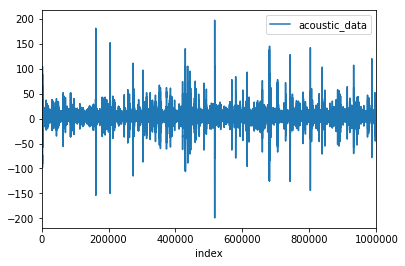

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline  
#X_train_scaled.reset_index().plot(x='index', y='mean')
train.reset_index().plot(x='index', y='acoustic_data')
plt.show()

### Try SSA on first 1000 rows of acoustic data

<class 'numpy.ndarray'>
[12  6  8]
tseries
selforig
0    12
1     6
2     8
dtype: int16


<Figure size 1600x640 with 0 Axes>

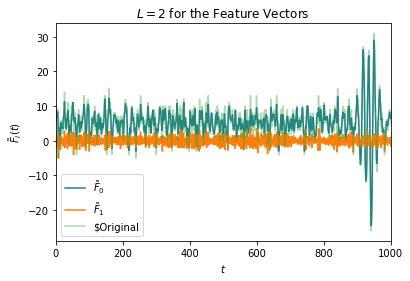

In [8]:
#F0=x_train
#print(F0[:3])
#print(type(F0['mean_roll_std_10']))
#F=np.array(F0['mean_roll_std_10'])
F=np.array(train['acoustic_data'])
F=F[:1000]
F_ssa_L2 = SSA(F, 2)
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1$",
           r"$Original"]);
plt.title(r"$L=2$ for the Feature Vectors");

### effect of SSA is can be more clear with smaller sample

## Try first 120 rows of acoustic data

<class 'numpy.ndarray'>
[12  6  8]
tseries
selforig
0    12
1     6
2     8
dtype: int16


Text(0.5, 1.0, 'W-Correlation for Acoustic Time Series, $L=20$')

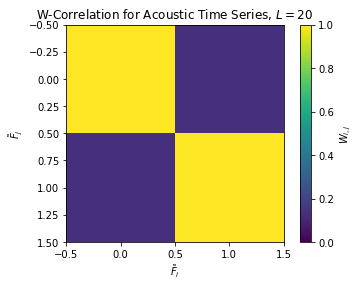

In [10]:
F=F[:120]
F_ssa_L2 = SSA(F, 2)
F_ssa_L2.plot_wcorr()
plt.title("W-Correlation for Acoustic Time Series, $L=20$")

<Figure size 1600x640 with 0 Axes>

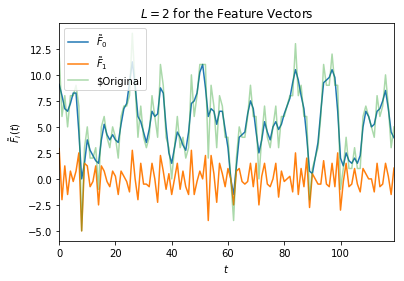

In [11]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1$",
           r"$Original"]);
plt.title(r"$L=2$ for the Feature Vectors");

#### first component appears to capture original well, while 2nd component appears as noise

## Try 5 components

<class 'numpy.ndarray'>
[12  6  8]
tseries
selforig
0    12
1     6
2     8
dtype: int16


Text(0.5, 1.0, 'W-Correlation for Acoustic Time Series, $L=20$')

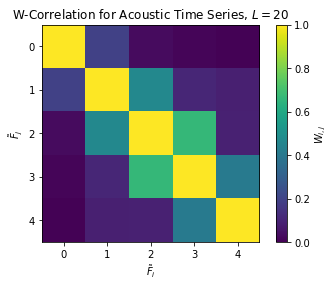

In [14]:
F_ssa_L5 = SSA(F, 5)
F_ssa_L5.plot_wcorr()
plt.title("W-Correlation for Acoustic Time Series, $L=20$")

<Figure size 1120x1440 with 0 Axes>

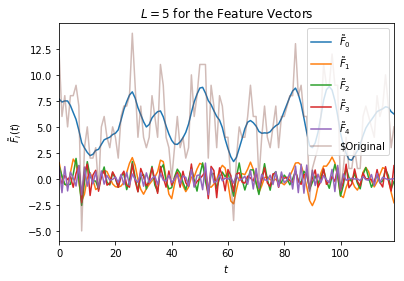

In [15]:
plt.figure(figsize=(14, 18), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the Feature Vectors");
plt.legend([r"$\tilde{F}_0$", r"$\tilde{F}_1$",r"$\tilde{F}_2$",
            r"$\tilde{F}_3$",r"$\tilde{F}_4$",r"$Original"]);

#### F0 is denoised, F1 is period (maybe F2 also?), F3/F4 are noise

## Now try 20 components

<class 'numpy.ndarray'>
[12  6  8]
tseries
selforig
0    12
1     6
2     8
dtype: int16


Text(0.5, 1.0, 'W-Correlation for Acoustic Time Series, $L=20$')

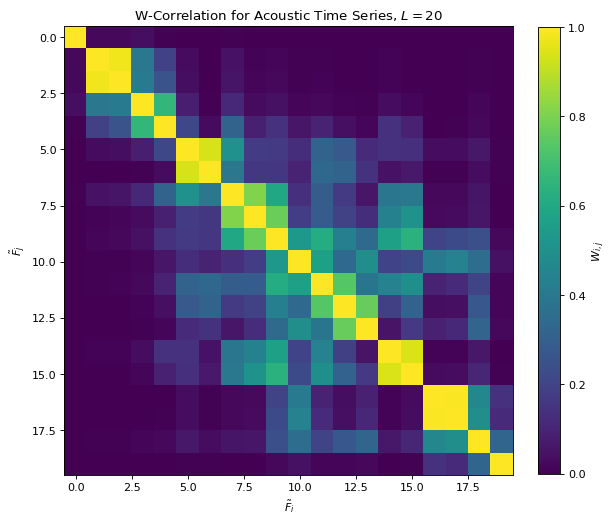

In [16]:
plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for Acoustic Time Series, $L=20$")

#### F0-F4 appear to have minimal correlation with F5-F19, so try 3 groups: F0, F1-F4, F5-19

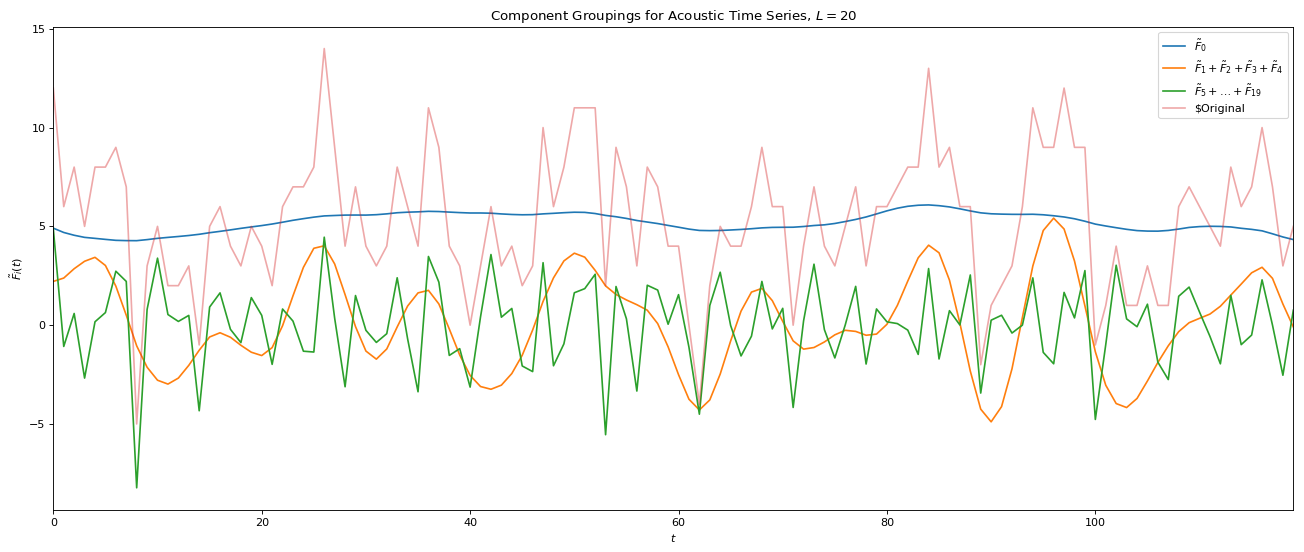

In [17]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2,3,4]).plot()
F_ssa_L20.reconstruct(slice(5,20)).plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Acoustic Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3+\tilde{F}_4$", 
            r"$\tilde{F}_5+ \ldots + \tilde{F}_{19}$",
           r"$Original"]);

#### Try 2 groups: F0-F4, F5-19

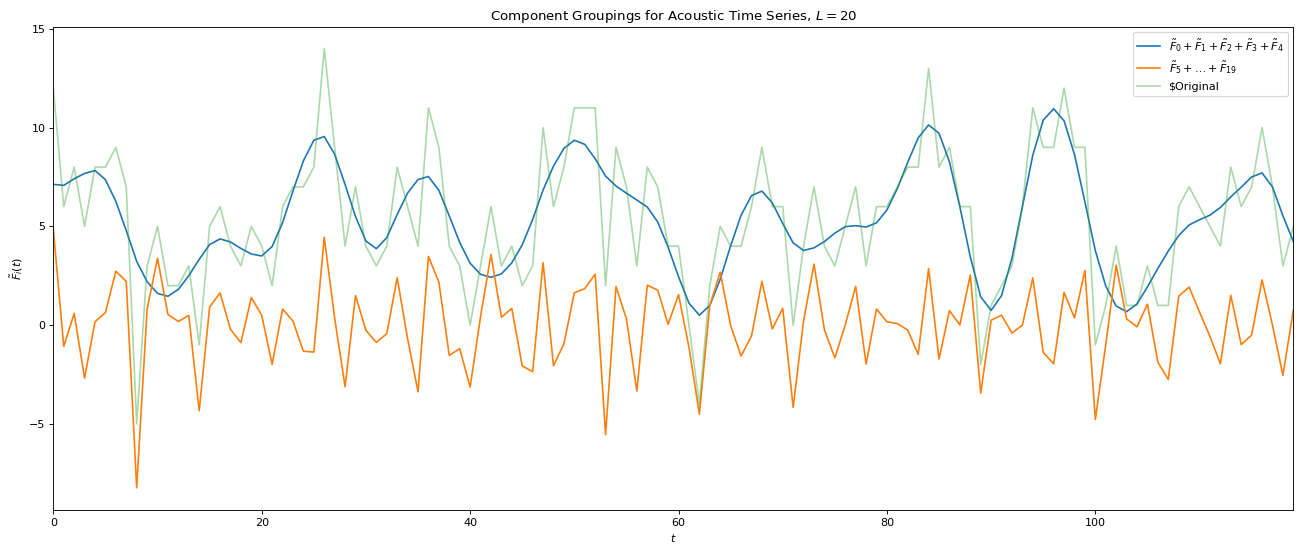

In [18]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L20.reconstruct([0,1,2,3,4]).plot()
F_ssa_L20.reconstruct(slice(5,20)).plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Acoustic Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0+\tilde{F}_1+\tilde{F}_2+\tilde{F}_3+\tilde{F}_4$", 
            r"$\tilde{F}_5+ \ldots + \tilde{F}_{19}$",
           r"$Original"]);

### Try 40 Components

<class 'numpy.ndarray'>
[12  6  8]
tseries
selforig
0    12
1     6
2     8
dtype: int16


Text(0.5, 1.0, 'W-Correlation for Acoustic Time Series, $L=40$')

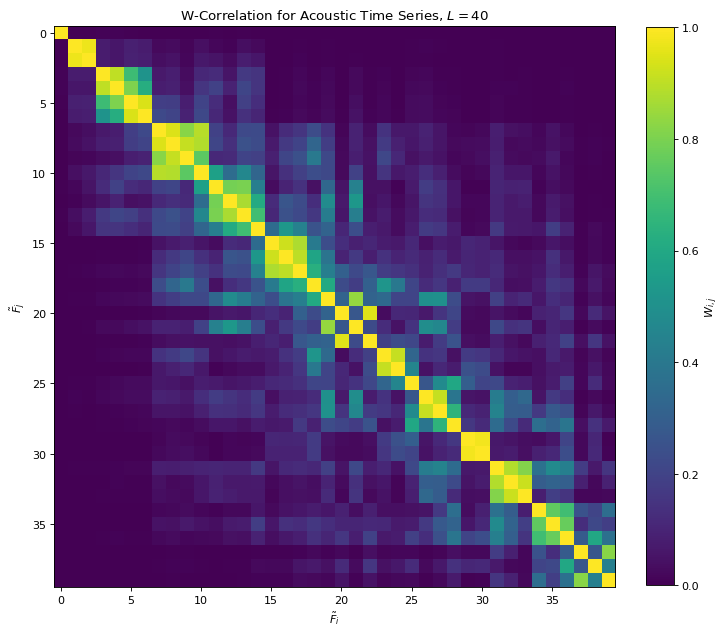

In [19]:
plt.figure(figsize=(10, 16), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L40 = SSA(F, 40)
F_ssa_L40.plot_wcorr()
plt.title("W-Correlation for Acoustic Time Series, $L=40$")

#### Try 4 groups: F0, F1-F2, F3-6, F7-39

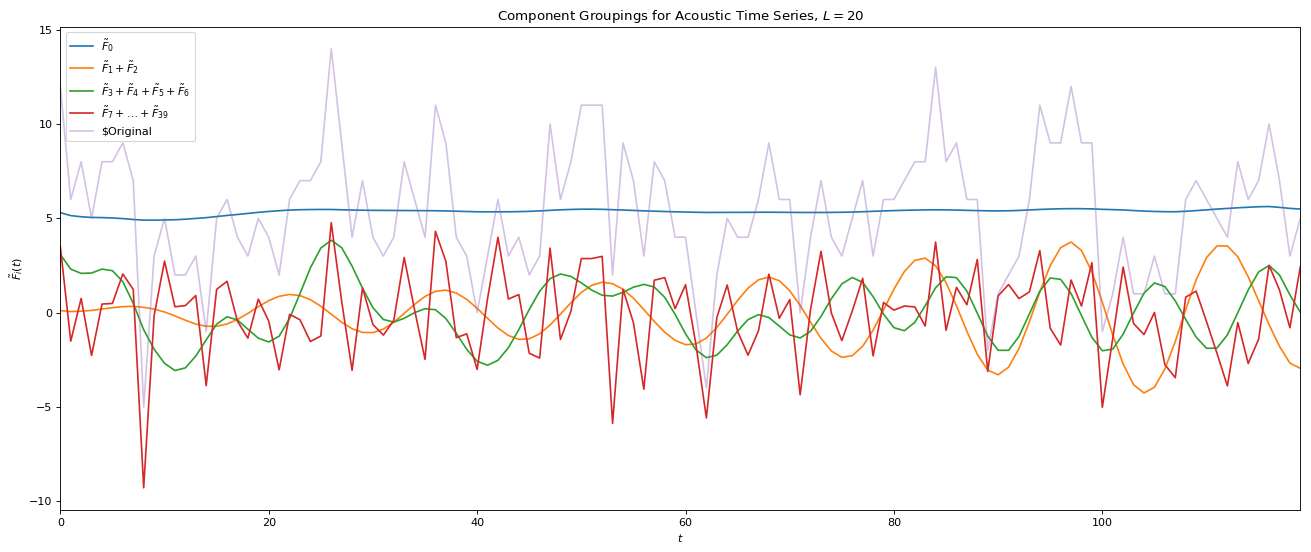

In [20]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L40.reconstruct(0).plot()
F_ssa_L40.reconstruct([1,2]).plot()
F_ssa_L40.reconstruct([3,4,5,6]).plot()
F_ssa_L40.reconstruct(slice(7,40)).plot()
F_ssa_L40.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Acoustic Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_3+\tilde{F}_4+\tilde{F}_5+\tilde{F}_6$", 
            r"$\tilde{F}_7+ \ldots + \tilde{F}_{39}$",
           r"$Original"]);

#### Try 3 groups: F0, F1-6, F7-39

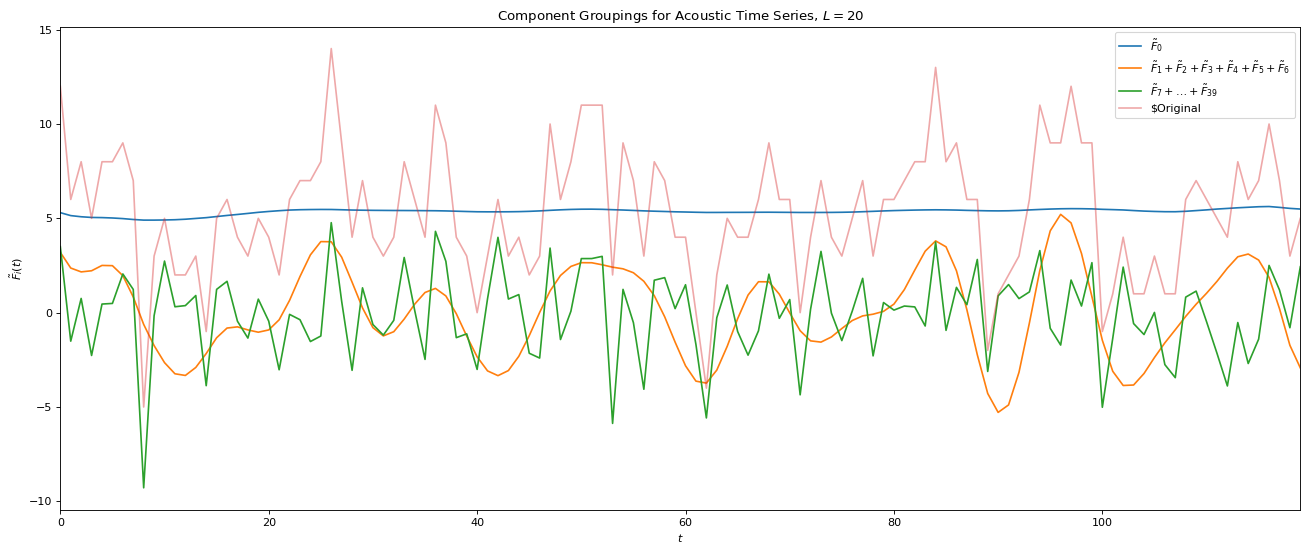

In [22]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L40.reconstruct(0).plot()
F_ssa_L40.reconstruct([1,2,3,4,5,6]).plot()
F_ssa_L40.reconstruct(slice(7,40)).plot()
F_ssa_L40.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Acoustic Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3+\tilde{F}_4+\tilde{F}_5+\tilde{F}_6$", 
            r"$\tilde{F}_7+ \ldots + \tilde{F}_{39}$",
           r"$Original"]);

#### Try groups F0-F6, F7-F39

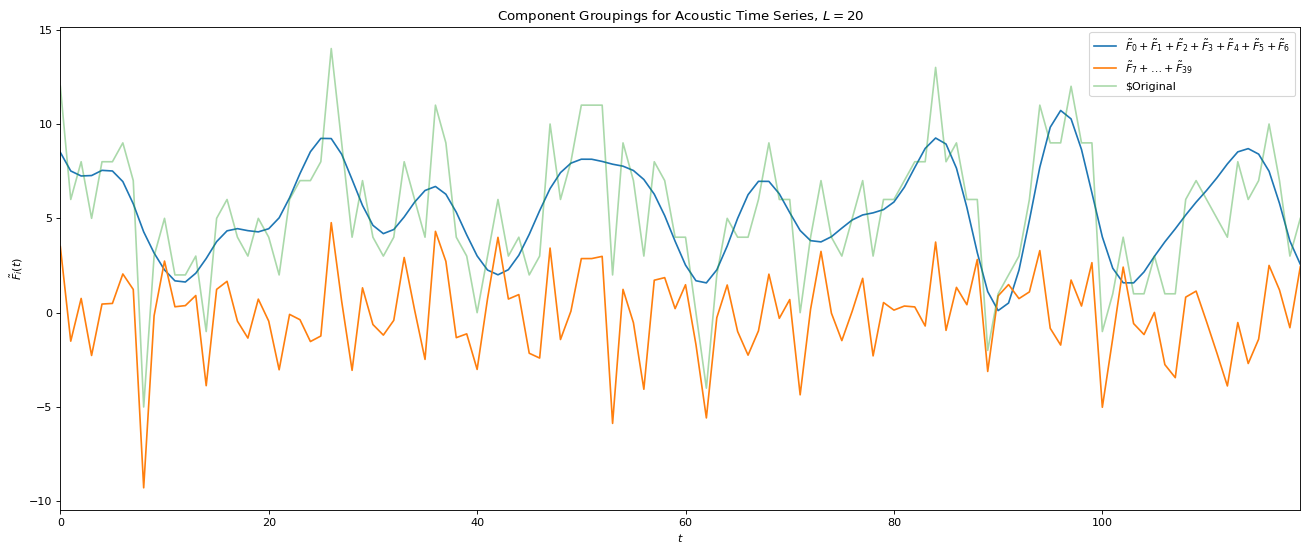

In [23]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L40.reconstruct([0,1,2,3,4,5,6]).plot()
F_ssa_L40.reconstruct(slice(7,40)).plot()
F_ssa_L40.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Acoustic Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0+\tilde{F}_1+\tilde{F}_2+\tilde{F}_3+\tilde{F}_4+\tilde{F}_5+\tilde{F}_6$", 
            r"$\tilde{F}_7+ \ldots + \tilde{F}_{39}$",
           r"$Original"]);

### Try L=60 components

<class 'numpy.ndarray'>
[12  6  8]
tseries
selforig
0    12
1     6
2     8
dtype: int16


Text(0.5, 1.0, 'W-Correlation for Acoustic Time Series, $L=60$')

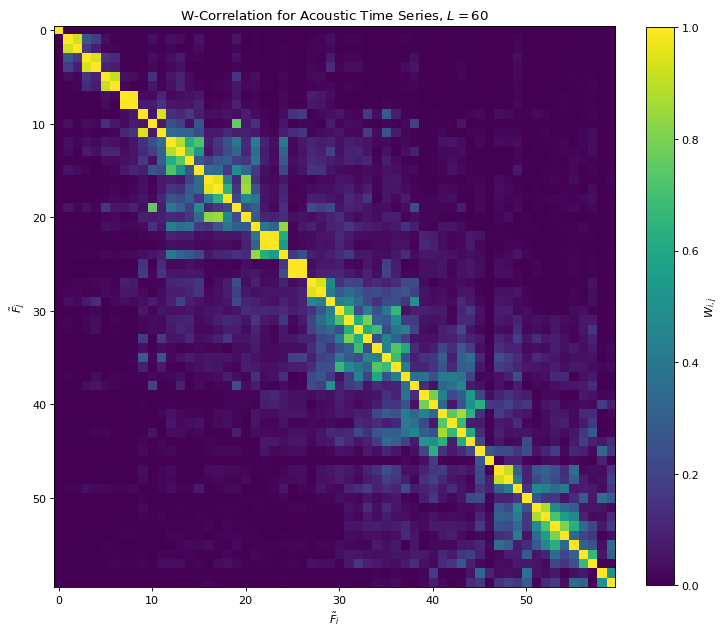

In [24]:
plt.figure(figsize=(10, 16), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L60 = SSA(F, 60)
F_ssa_L60.plot_wcorr()
plt.title("W-Correlation for Acoustic Time Series, $L=60$")

#### Try F0-F8, F9-F59

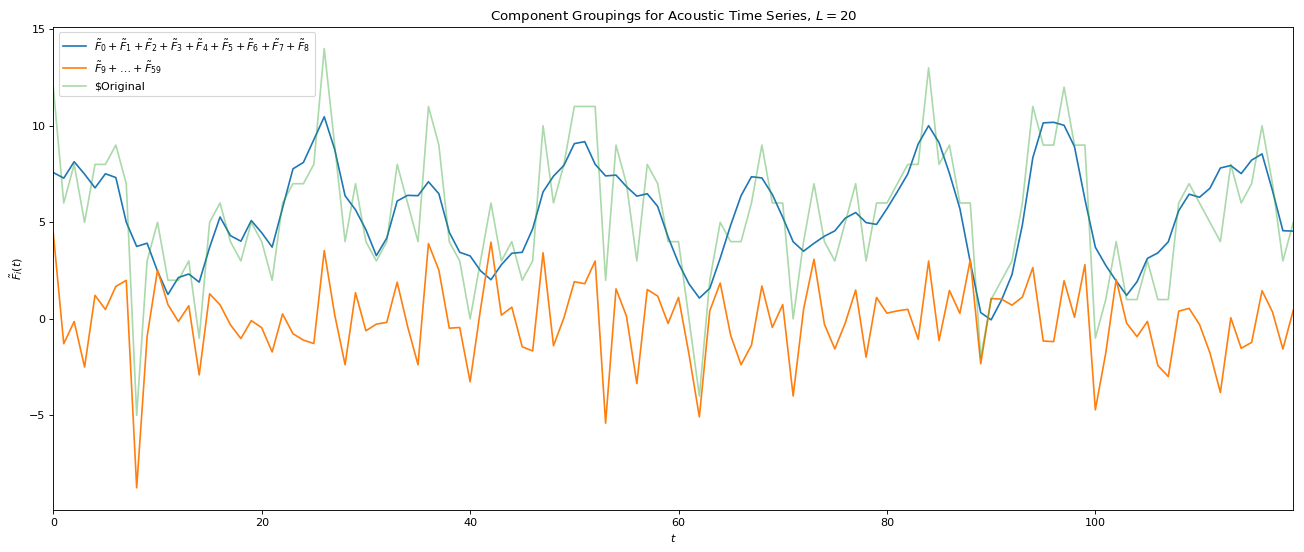

In [25]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L40.reconstruct([0,1,2,3,4,5,6,7,8]).plot()
F_ssa_L40.reconstruct(slice(9,60)).plot()
F_ssa_L40.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Acoustic Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0+\tilde{F}_1+\tilde{F}_2+\tilde{F}_3+\tilde{F}_4+\tilde{F}_5+\tilde{F}_6+\tilde{F}_7+\tilde{F}_8$", 
            r"$\tilde{F}_9+ \ldots + \tilde{F}_{59}$",
           r"$Original"]);

## try SSA on the "mean" feature vector

In [28]:
X_save_scaled = "X_tr_scaled.csv"
X_train_scaled = pd.read_csv(X_save_scaled, index_col=0)

#### Try 5 components on entire "mean" feature vector

<class 'numpy.ndarray'>
[1.4241405  0.80571603 1.51115526]
tseries
selforig
0    1.424140
1    0.805716
2    1.511155
dtype: float64


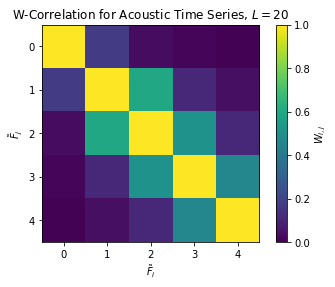

<Figure size 1120x1440 with 0 Axes>

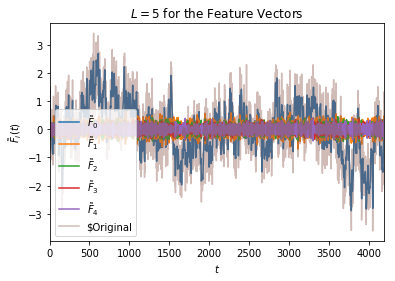

In [29]:
F=np.array(X_train_scaled['mean'])
#F=F[:5000]

F_ssa_L5 = SSA(F, 5)
F_ssa_L5.plot_wcorr()
plt.title("W-Correlation for Acoustic Time Series, $L=20$")


plt.figure(figsize=(14, 18), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the Feature Vectors");
plt.legend([r"$\tilde{F}_0$", r"$\tilde{F}_1$",r"$\tilde{F}_2$",
            r"$\tilde{F}_3$",r"$\tilde{F}_4$",r"$Original"]);

### Try 20 components

<class 'numpy.ndarray'>
[1.4241405  0.80571603 1.51115526]
tseries
selforig
0    1.424140
1    0.805716
2    1.511155
dtype: float64


Text(0.5, 1.0, 'W-Correlation for Acoustic Time Series, $L=20$')

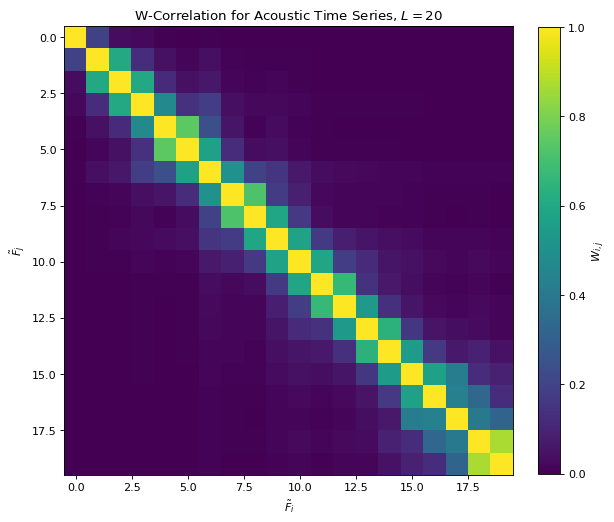

In [30]:
plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for Acoustic Time Series, $L=20$")

### Not very clear from plot on how to divide groups => try more components

## Try 100 components

<class 'numpy.ndarray'>
[1.4241405  0.80571603 1.51115526]
tseries
selforig
0    1.424140
1    0.805716
2    1.511155
dtype: float64


Text(0.5, 1.0, 'W-Correlation for Acoustic Time Series, $L=20$')

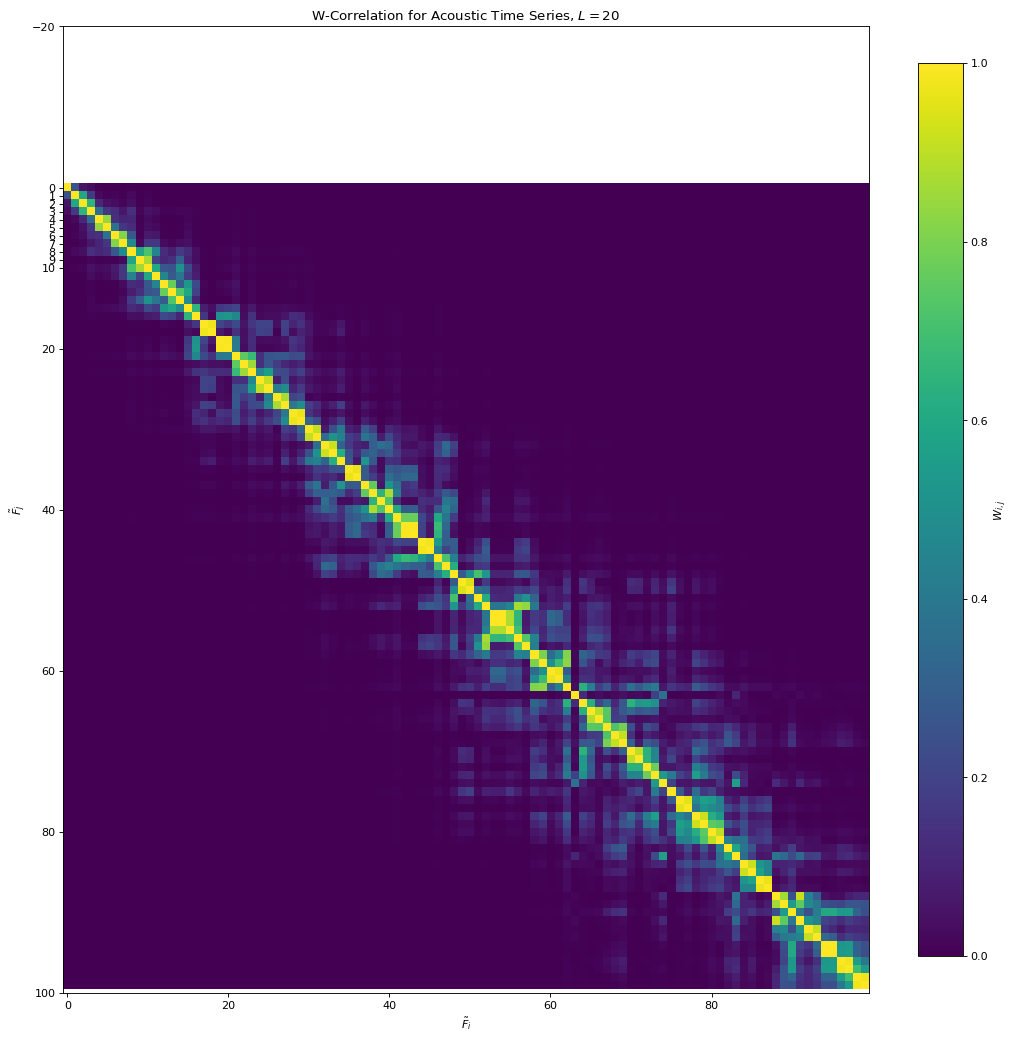

In [31]:
plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L100 = SSA(F, 100)
F_ssa_L100.plot_wcorr()
extraticks=[1,2,3,4,5,6,7,8,9,10]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.title("W-Correlation for Acoustic Time Series, $L=20$")

#### Try grouping F0-F7, F8-F99

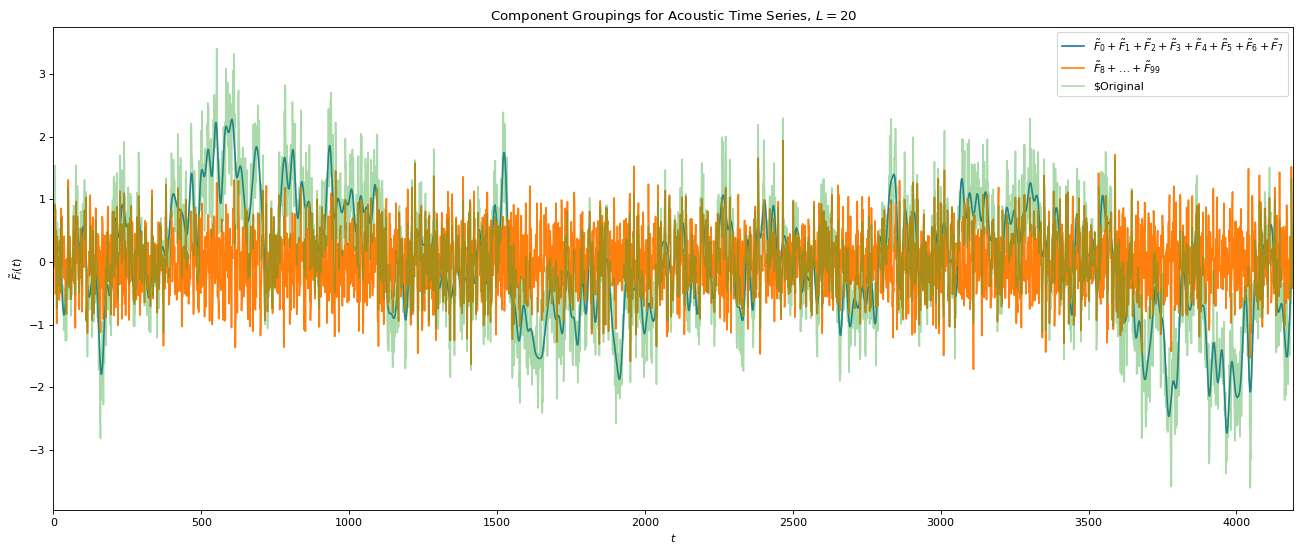

In [32]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L100.reconstruct([0,1,2,3,4,5,6,7]).plot()
F_ssa_L100.reconstruct(slice(8,100)).plot()
F_ssa_L100.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Acoustic Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0+\tilde{F}_1+\tilde{F}_2+\tilde{F}_3+\tilde{F}_4+\tilde{F}_5+\tilde{F}_6+\tilde{F}_7$", 
            r"$\tilde{F}_8+ \ldots + \tilde{F}_{99}$",
           r"$Original"]);

### Plot F0-F7 vs Original to see if F0-F7 looks like denoised of original mean vector

   DenoisedMean
0      0.941327
1      0.896571
2      0.850422
3      0.784931
4      0.708466


0    1.424140
1    0.805716
2    1.511155
3    1.494934
4    1.520242
Name: mean, dtype: float64


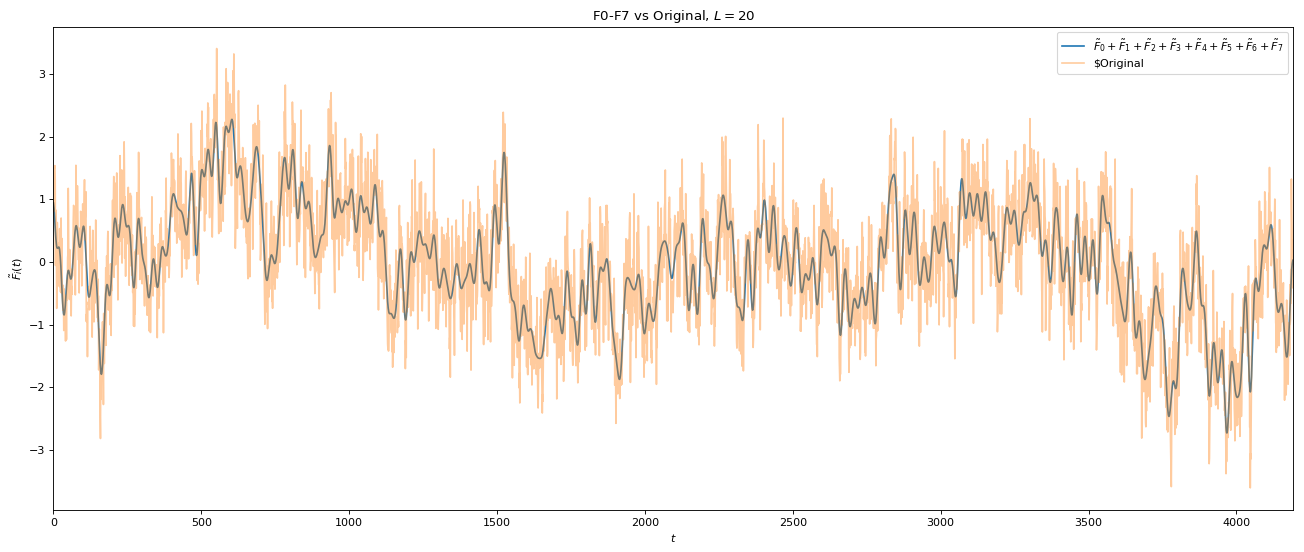

In [33]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
#F_ssa_L100.reconstruct([0,1,2,3,4,5,6,7]).plot()
F_ssa_L100.F0_F7=F_ssa_L100.reconstruct([0,1,2,3,4,5,6,7])
F_ssa_L100.F0_F7.plot()
F_ssa_L100.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("F0-F7 vs Original, $L=20$");
plt.legend([r"$\tilde{F}_0+\tilde{F}_1+\tilde{F}_2+\tilde{F}_3+\tilde{F}_4+\tilde{F}_5+\tilde{F}_6+\tilde{F}_7$", 
           r"$Original"]);

F_ssa_L100.F0_F7_df=pd.DataFrame(F_ssa_L100.F0_F7)
F_ssa_L100.F0_F7_df.columns = ['DenoisedMean']
print(F_ssa_L100.F0_F7_df.head())
print("\n")
print(X_train_scaled['mean'].head())

### Plot F8-F99 vs Original to see if  F8-F99 looks like noise

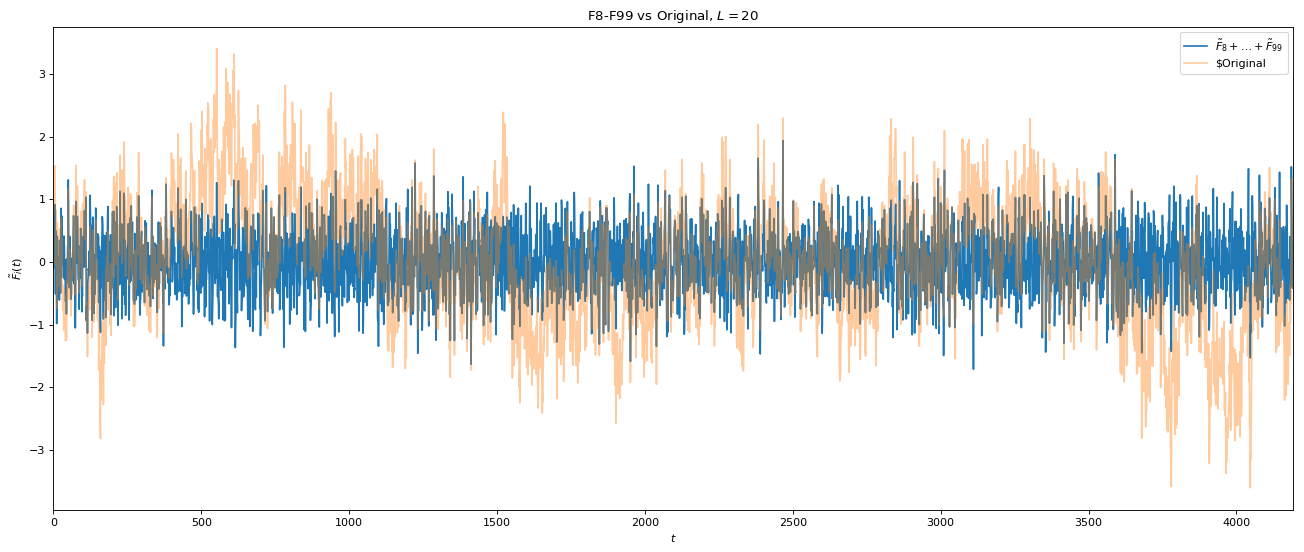

In [34]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
F_ssa_L100.reconstruct(slice(8,100)).plot()
F_ssa_L100.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("F8-F99 vs Original, $L=20$");
plt.legend([r"$\tilde{F}_8+ \ldots + \tilde{F}_{99}$",
           r"$Original"]);

### When using SSA on the "mean" feature vector and breaking it into 100 components, it seems the first 8 components capture the trend + periodicity, while the rest of the components capture the noise